<a href="https://colab.research.google.com/github/DuyDucNguyen/Practical_FEM_FEniCS_Colab/blob/master/adaptive_mesh_Navier_Stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adaptive Mesh Refinement for Navier-Stokes Equation

In [0]:
# This program shows how to automately apply adaptive mesh refinement for Navier-Stokes Equation

# Reference: This program is followed the ideas in last chapter of the course 'edx.org - KTHx - High Performance Finite Element Modeling'. 
# The author modifies it up to date and give clear explaination.  

# Copyright (C) 2019 Duy Duc NGUYEN (duyduc.nguyen@protonmail.com)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2019-09-23
# Last changed: 2019-09-23

# This demo is maintained by Duy Duc NGUYEN
# Please report possible problems to duyduc.nguyen@protonmail.com

In [3]:
# install Fenics: 2 mins
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

dolfin version: 2019.1.0


**Primial problem:** The Steady-state Navier-Stokes equations
\begin{equation}
\left\{ \begin{array}{ccc}
\left(\boldsymbol{u}\cdot\nabla\right)\boldsymbol{u}+\nabla p-\nu\Delta\boldsymbol{u}=f & \text{ in } & \Omega\\
\nabla\cdot\boldsymbol{u}=0 & \text{ in } & \Omega
\end{array}\right.
\end{equation}

where $\boldsymbol{u}=\left(u_{1},u_{2}\right)$ is vector field,
$p$ is pressure, $\nu=4E-3$ is viscosity 

Boundary conditions

Wall BC: $\Gamma_{top},\Gamma_{bot}$

Inner BC: 

Inflow: $u=\left(4y\frac{y_{max}-y}{y_{max}^{2}},0\right)$$\Gamma_{left}$

Outflow: $\Gamma_{right}$

$\psi=$marker takes 1 on the $\Gamma_{int}$, 0 otherwise

adapt\_ratio = 0.2

Residual
\begin{equation}
(\boldsymbol{u}\cdot\nabla)\boldsymbol{u}=\left(u_{i}\frac{\partial}{\partial x_{i}}\right)\boldsymbol{u}=\left(u_{i}\frac{\partial u_{i}}{\partial x_{i}}\right)
\end{equation}
\begin{align*}
\int_{\Omega}(\boldsymbol{u}\cdot\nabla)\boldsymbol{u}\overline{p}+\nabla p\overline{p}\ \mathrm{d}x-\nu\int_{\Omega}\Delta\boldsymbol{u}\overline{p}\ \mathrm{d}x-\int_{\Omega}f\overline{p}\ \mathrm{d}x & =0\\
\int_{\Omega}\nabla\cdot\boldsymbol{u}\overline{\boldsymbol{u}}\ \mathrm{d}x & =0
\end{align*}

**Goal functions:**

strain tensor: $\boldsymbol{\epsilon}\left(u\right)=\frac{1}{2}\left(\nabla u+\nabla u^{T}\right)$

stress tensor: $\boldsymbol{\sigma}\left(u\right)=pI-\nu\epsilon\left(u\right)$

Drag force: $M=\int_{\Gamma_{int}}pn_{1}\ \mathrm{d}s$

Lift force: $M=\int_{\Gamma_{int}}pn_{2}\ \mathrm{d}s$

Drag force: $M=\int_{\Gamma_{int}}\boldsymbol{\sigma}\cdot\boldsymbol{n}\ $ds

**Dual problem**

**Error indicator**

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
------------------------
output: 0.06103 est: 0.06000 err: 0.08078 cells: 98 vertices: 69 interation: 0
------------------------
adaptive mesh
------------------------
output: 0.12023 est: 0.08490 err: 0.02158 cells: 172 vertices: 110 interation: 1
------------------------
adaptive mesh
------------------------
output: 0.10817 est: 0.03892 err: 0.03364 cells: 287 vertices: 175 interation: 2
------------------------
adaptive mesh
------------------------
output: 0.11727 est: 0.01777 err: 0.02454 cells: 551 vertices: 316 interation: 3
------------------------
adaptive mesh
------------------------
output: 0.12032 est: 0.00855 err: 0.02149 cells: 1073 vertices: 589 interation: 4
------------------------
adaptive mesh


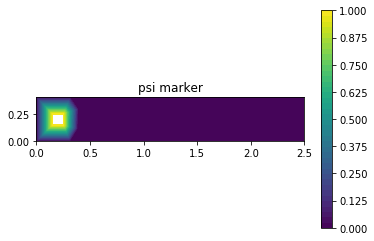

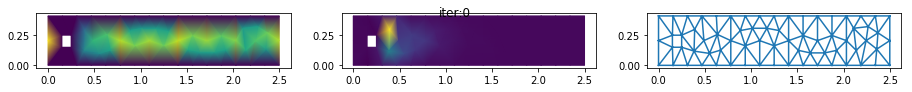

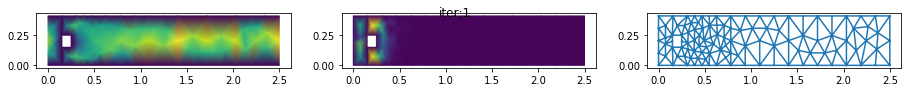

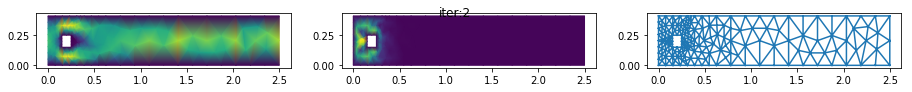

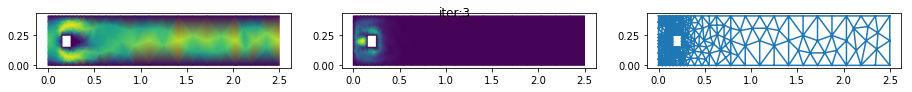

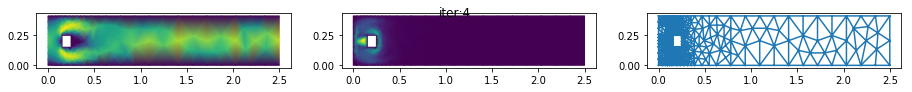

In [4]:
from mshr import *
import matplotlib.pyplot as plt
import time
import os

set_log_active(False)

# Set Fenics parameter

# Use compiler optimizations
parameters["form_compiler"]["cpp_optimize"] = True

# Allow approximating values for points that may be generated outside of domain (because of numerical inaccuracies)
parameters["allow_extrapolation"] = True



# Known coefficients
u0_0  = Constant((0.0, 0.0))
f     = Constant((0.0, 0.0))
u0_0p = Constant(0.0)
nu    = 4e-3 # Viscosity


#Maximum iterations
maxiters = 5 



# define geometry
resolution=10
Y_MAX = 0.41
X_MAX = 2.5
XMIN=0.;  YMIN=0;  G=[XMIN, X_MAX, YMIN, Y_MAX];
ghole = [0.15, 0.25, 0.15, 0.25];



# Fraction of the cells to refine
adapt_ratio = 0.2



# generate mesh
mesh = generate_mesh(Rectangle(Point(G[0],G[2]), Point(G[1],G[3])) -Rectangle(Point(ghole[0],ghole[2]),Point(ghole[1],ghole[3]) ), resolution)


# Define boundaries
class WallBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and( x[1] > Y_MAX - DOLFIN_EPS or x[1] < DOLFIN_EPS)


class InnerBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0] > XMIN+DOLFIN_EPS and x[1] > YMIN+DOLFIN_EPS and x[0] < X_MAX-DOLFIN_EPS and x[1] < Y_MAX-DOLFIN_EPS)


class InflowBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and(x[0] <  DOLFIN_EPS )

   
class OutflowBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and(x[0] > X_MAX - DOLFIN_EPS )


# define boundary conditions
class Inflow(UserExpression):
    def eval(self, values, x):
        values[0] = 4*1.0*(x[1]*(Y_MAX-x[1]))/(Y_MAX*Y_MAX)
        values[1] = 0
    def value_shape(self):
        return (2,)


class PsiMarker(UserExpression):
	def eval(self, values, x):
		ib = InnerBoundary()
		tol = 1E-8
		cond0 = ghole[0]-tol <= x[0] and x[0] <= ghole[1]+tol
		cond1 = ghole[2]-tol <= x[1] and x[1] <= ghole[3]+tol
		if(ib.inside(x, True) and cond0 and cond1):
			values[0] = 1.0
		else:
			values[0] = 0.0






V = FunctionSpace(mesh, 'DG', 1)
psimarker = PsiMarker(degree = 2, element = V.ufl_element())

plt.figure()
p = plot( interpolate(psimarker, V ) )
plt.colorbar(p)
plt.title('psi marker')





# Define goal function
def M(mesh, u, p):
	# stress tensor
	def epsilon(z):
		return 0.5*(grad(z) + grad(z).T) # 1/2(grad(u)+grad(u)^T)

	n = FacetNormal(mesh)

	I = Identity(2)
	sigma = p*I - nu*epsilon(u)
	theta = Constant((1.0, 0.0))

	g = Expression(("200.0*exp(-200.0*(pow(x[0] - 0.5, 2) + pow(x[1] - 0.3, 2)))", "0.0"), degree=2, domain=mesh)


	M1 = psimarker*p*n[0]*ds # Drag (only pressure)
	M2 = psimarker*p*n[1]*ds # Lift (only pressure)
	M3 = inner(g, u)*dx # Mean of the velocity in a region
	M4 = psimarker*dot(dot(sigma, n), theta)*ds # Drag (full stress)
	M5 = u[0]*dx # Mean of the x-velocity in the whole domain

	return M1



# The strong residual with w the solution (w2 used for simple linerization) 
def R(w, w2):
    (u, p) = (as_vector((w[0], w[1])), w[2])
    (u2, p2) = (as_vector((w2[0], w2[1])), w2[2])

    Au = grad(p) + grad(u2)*u
    Ap = div(u)

    Aui = [Au[i] for i in range(0, 2)]

    return as_vector(Aui + [Ap])



# The weak residual with w the solution and wt the test function ei_mode : Error Indicator
# stab : Stability
def r(W, w, wt, ei_mode=True, stab=True):
    # Velocity and pressure
    (u, p) = ( as_vector((w[0], w[1])), w[2] )

    # v=(v1, v2) test function of u; q test function of p
    (v, q) = ( as_vector((wt[0], wt[1])), wt[2] ) 

    h = W.mesh().hmin()
    delta = h

    # Discontinuous Galerkin element
    Z = FunctionSpace(W.mesh(), "DG", 0)
    z = TestFunction(Z)

    if(not stab):
        delta = 0.0

    if(not ei_mode):
        z = 1.0

    # Define variational forms
    # Multiply by z to be able to extract error indicators for each cell
    dx = Measure("dx", domain=W.mesh())
    a_G = z*(nu*inner(grad(u), grad(v)) + inner(grad(p) + grad(u)*u, v) + div(u)*q)*dx
    a_stab = z*delta*inner(R(w, w), R(wt, w))*dx # Stabilization
    a = a_G + a_stab
    L = z*inner(f, v)*dx
    F = a - L

    return F




# Solve primal and dual equations and compute error indicators
def adaptive_solve(mesh):
	global u0_0

	h = mesh.hmin()

	# Define function spaces
	Z = FunctionSpace(mesh, "DG", 0)


	fi_ele = FiniteElement('CG', mesh.ufl_cell(), 1)
	vector_element = MixedElement([fi_ele, fi_ele])
	scalar_element = fi_ele
	elements       = MixedElement([vector_element, scalar_element])
	W       = FunctionSpace(mesh, elements)



	# primal solver boundary conditions
	bc_0_0  = DirichletBC(W.sub(0), u0_0, WallBoundary())
	bc_0_1  = DirichletBC(W.sub(0), u0_0, InnerBoundary())
	
	ifp = project( Inflow(element = W.sub(0).ufl_element(), degree=2), W.sub(0).collapse())

	bc_0_2  = DirichletBC(W.sub(0), ifp, InflowBoundary())
	
	bc_0_3p = DirichletBC(W.sub(1), u0_0p, OutflowBoundary())


 	# Define unknown and test function(s)
	(v, q) = TestFunctions(W)
	wt = TestFunction(W)
	w = Function(W)
	phi = Function(W)
	(u, p) = (as_vector((w[0], w[1])), w[2])
	n = FacetNormal(mesh)


	# The variational form
	F = r(W, w, wt, ei_mode=False, stab=True)


	# Primal boundary conditions
	bcs = [bc_0_0, bc_0_1, bc_0_2, bc_0_3p]


	# Solve the primal problem
	solve( F==0, w, bcs )

    
	# Compute output
	output = assemble(M(mesh, u, p))

	# Project output functional
	(ut, pt) = TrialFunctions(W)
	a_psi = inner(ut, v)*dx + inner(pt, q)*dx 
	L_psi = M(mesh, v, q)
	psi   = Function(W)
	solve(a_psi == L_psi, psi)


	# Generate the dual problem
	# a_star = derivative(F, w, wt)
	a_star = adjoint(derivative(F, w))   #a^*
	(phi_u, phi_p) = (as_vector((phi[0], phi[1])), phi[2])
    
	L_star = M(mesh, v, q)               #L^*

	# Generate dual boundary conditions
	for bc in bcs:
		bc.homogenize()

	# Solve the dual problem
	solve(a_star == L_star, phi, bcs)

	# Generate error indicators
	z = TestFunction(Z)

	(u, p) = w.split()
	(phi_u, phi_p) = phi.split()
	(psi_u, psi_p) = psi.split()

	# Compute error indicators ei
	LR1 = r(W, w, phi, ei_mode=True, stab=False)
	ei = Function(Z)
	ei.vector()[:] = assemble(LR1)[:]

	return (u, p, phi_u, phi_p, psi_u, psi_p, output, ei) 



# Refine the mesh based on error indicators
def adaptive_refine(mesh, ei, adapt_ratio, adaptive):
	gamma = abs(ei.vector()[:])

	# Mark cells for refinement
	cell_markers = MeshFunction("bool", mesh, mesh.topology().dim())
	gamma_0 = sorted(gamma, reverse=True)[int(len(gamma)*adapt_ratio) - 1]
	gamma_test = sorted(gamma, reverse=True)
	#print(gamma_test)
	#print(gamma_0)
	for c in cells(mesh):
		cell_markers[c] = gamma[c.index()] > gamma_0

	# Refine mesh
	if adaptive:
		print('adaptive mesh')
		mesh = refine(mesh, cell_markers)
	else:
		print('refine all mesh')
		mesh = refine(mesh)
	return mesh




# ======== plot ========
import matplotlib.tri as tri
def mesh2triang(mesh):
	xy = mesh.coordinates()
	return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())



def mplot_function(f):
	mesh = f.function_space().mesh()
	if (mesh.geometry().dim() != 2):
		raise AttributeError('Mesh must be 2D')

	# DG0 cellwise function
	if f.vector().size() == mesh.num_cells():
		C = f.vector().array()
		return plt.tripcolor(mesh2triang(mesh), C)

	# Scalar function, interpolated to vertices
	elif f.value_rank() == 0:
		C = f.compute_vertex_values(mesh)
		return plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')

	# Vector function, interpolated to vertices
	elif f.value_rank() == 1:
		w0 = f.compute_vertex_values(mesh)
		if (len(w0) != 2*mesh.num_vertices()):
			raise AttributeError('Vector field must be 2D')

	X = mesh.coordinates()[:, 0]
	Y = mesh.coordinates()[:, 1]
	U = w0[:mesh.num_vertices()]
	V = w0[mesh.num_vertices():]
	return plt.quiver(X,Y,U,V)





def solve_problem(mesh,adaptive=True):
	# Mesh
	# mesh = Mesh("turek.xml")
	results = []
	# Adaptive loop
	for i in range(0, maxiters):
		#print(maxiters)
		# Solve primal and dual equations and compute error indicators
		(u, p, phi_u, phi_p, psi_u, psi_p, output, ei) = adaptive_solve(mesh)
	
		# Compute error estimate and compare against reference value
		est = abs(sum(ei.vector()[:]))
		ref = 0.14181 # From experience or reference solution
		err = abs(ref - output)
		result = (output, est, err, mesh.num_cells())
		results.append(result)
		print("------------------------")
		print("output: %5.5f est: %5.5f err: %5.5f cells: %d vertices: %d interation: %d" % (output, est, err, mesh.num_cells(),mesh.num_vertices(),i))
		print("------------------------")
		# Functionspace used for plotting
		Q = FunctionSpace(mesh, "CG", 1)
        
		plt.figure(figsize=(15.5,1.));
		plt.suptitle("iter:%d"%(i));
		plt.subplot(1,3,1);
		mplot_function(project(sqrt(inner(u, u)), Q)); # Plot???
		plt.subplot(1,3,2);
		mplot_function(project(sqrt(phi_u[0]**2 + phi_u[1]**2), Q))
		plt.subplot(1,3,3);
		plt.triplot(mesh2triang(mesh))
        
		# Refine the mesh
		mesh = adaptive_refine(mesh, ei, adapt_ratio, adaptive)
	plt.show()



# Solve the problem
solve_problem(mesh, adaptive=True)

